In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
sys.path.insert(0,'/home/users/eboland/smurphs/python')
import utils

In [2]:
# Directories for saving plots and finding input data
figs_dir = '/home/users/eboland/smurphs_notebooks/'
data_dir='~/smurphs/data_out/smurphs_ensemble/'

# Experiment info, don't alter
exps=['historical0p2','historical0p4','historical0p7','historical1p0','historical1p5']
runs=['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r5i1p1f1']
exp_names=['0.2','0.4','0.7','1.0','1.5']
y_start=[1960,1980]
y_end=[1991,2011]
forc=xr.DataArray(coords={'exp':exps},data=[0.38,0.6,0.93,1.17,1.5],dims=['exp'],)

In [3]:
ohu_xy=[]
for tchunk in range(0,2):
    ohc_runs=xr.open_dataarray(data_dir+'ohcA_xy_trend_regrid_byrun_fd_'+str(y_start[tchunk])+str(y_end[tchunk])+'.nc')
    ohu_xy.append(ohc_runs)
ohu_xy=xr.concat(ohu_xy,'time')

In [4]:
# Plotting choices
atllims=[-60,15,35,80]
solims=[-90,-30]
atl_inds=(ohu_xy.lon>atllims[0])&(ohu_xy.lon<atllims[1])&(ohu_xy.lat>atllims[2])&(ohu_xy.lat<atllims[3])
so_inds=(ohu_xy.lat>solims[0])&(ohu_xy.lat<solims[1])
region_dict={'atl':{'inds':[atl_inds],'proj':ccrs.Orthographic(),'clims':[-20,20],'figsize':[15,3]},
            'so':{'inds':[so_inds],'proj':ccrs.SouthPolarStereo(),'clims':[-10,10],'figsize':[15,5]},
            'global':{'inds':None,'proj':ccrs.Robinson(central_longitude=-100),'clims':[-15,15],'figsize':[14,3]}}

regions=list(region_dict.keys()) 

In [5]:
all_stats=utils.lin_regress(forc.broadcast_like(ohu_xy).stack(exp_run=('exp','run')),ohu_xy.stack(exp_run=('exp','run')),[['exp_run'],['exp_run']])
slopes= all_stats.sel(parameter='slope')/1e6
t_score=all_stats.sel(parameter='r_value')*np.sqrt(25-2)/np.sqrt(1-all_stats.sel(parameter='r_value')**2)
tpval = stats.t.sf(np.abs(t_score),25-1)
sigs = slopes.copy(data=tpval<=0.05)

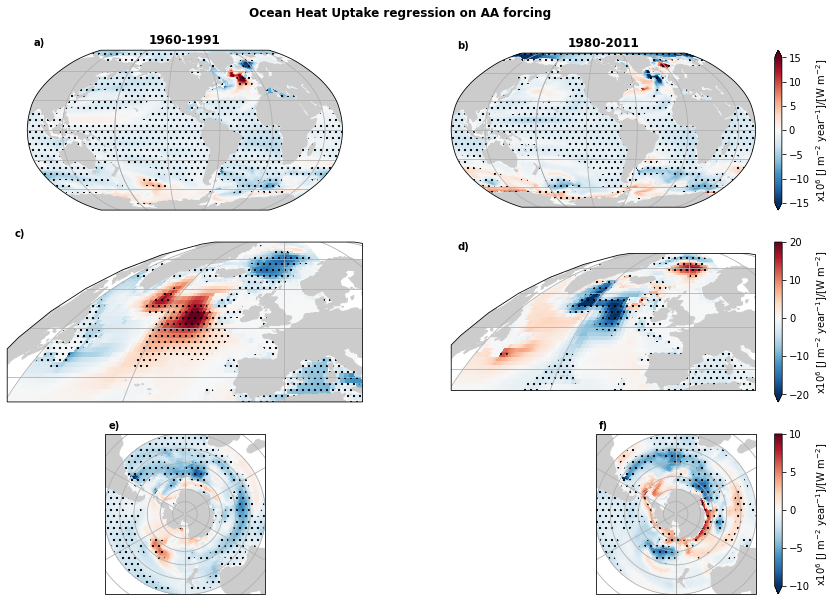

In [19]:
%matplotlib inline
fig=plt.figure(figsize=(15,10))
ip=1

for ir,region in enumerate(['global','atl','so']): 
    for it in range(0,2):
        ax=fig.add_subplot(3,2,ip,projection=region_dict[region]['proj'])
        if region_dict[region]['inds']:
            dplot_slope=slopes.where(region_dict[region]['inds'][0],drop=True).isel(time=it)
            dplot_sig=sigs.where(region_dict[region]['inds'][0],drop=True).isel(time=it)
        else:
            dplot_slope=slopes.isel(time=it)
            dplot_sig=sigs.isel(time=it)

        if it ==0:
            dplot_slope.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
                            vmin=region_dict[region]['clims'][0],vmax=region_dict[region]['clims'][1],
                           add_colorbar=False,ax=ax,
                          cmap='RdBu_r',rasterized=True)
        else:
            dplot_slope.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),ax=ax,
                            vmin=region_dict[region]['clims'][0],vmax=region_dict[region]['clims'][1],
                           cbar_kwargs={'label': 'x10$^6$ [J m$^{-2}$ year$^{-1}$]/[W m$^{-2}$]'},
                            cmap='RdBu_r',rasterized=True)
        ax.gridlines()
        ax.add_feature(cf.LAND,color=[0.8,0.8,0.8],zorder=1)
        dplot_sig.plot.contourf(x='lon',y='lat',alpha=0,levels=[-1,0,1],hatches=[None,'..'],transform=ccrs.PlateCarree(),add_colorbar=False,ax=ax)
        ax.text(0.02,1.03,'{})'.format(chr(ord('a')+ip-1)),fontweight='bold',transform=ax.transAxes)
        if ir==0:
            ax.set_title(str(y_start[it])+'-'+str(y_end[it]),fontweight='bold')
        else:
            ax.set_title('')
        ip=ip+1
plt.suptitle('Ocean Heat Uptake regression on AA forcing',weight='bold',y=0.94)
plt.savefig(figs_dir+'Fig6_ohu_xy_regress_regions.png',bbox_inches='tight')
plt.savefig(figs_dir+'Fig6_ohu_xy_regress_regions.pdf',bbox_inches='tight')

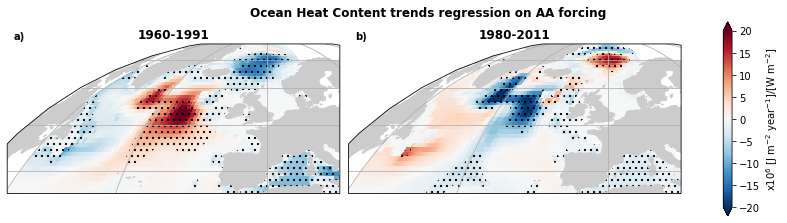

In [12]:
%matplotlib inline

region='atl'

dplot_slope=slopes.where(region_dict[region]['inds'][0],drop=True)
dplot_sig=sigs.where(region_dict[region]['inds'][0],drop=True)

#dplot_slope=slopes
#dplot_sig=sigs

p=dplot_slope.plot(x='lon',y='lat',col='time',transform=ccrs.PlateCarree(),
                   figsize=(12,3),
                    vmin=region_dict[region]['clims'][0],vmax=region_dict[region]['clims'][1],cbar_kwargs={'label': 'x10$^6$ [J m$^{-2}$ year$^{-1}$]/[W m$^{-2}$]'},
                  cmap='RdBu_r',rasterized=True,subplot_kws={'projection': region_dict[region]['proj']})
for ia,ax in enumerate(p.axes.flat):
    ax.gridlines()
    ax.add_feature(cf.LAND,color=[0.8,0.8,0.8],zorder=1)
    dplot_sig.isel(time=ia).plot.contourf(x='lon',y='lat',alpha=0,levels=[-1,0,1],hatches=[None,'..'],transform=ccrs.PlateCarree(),add_colorbar=False,ax=ax)
    ax.text(0.02,1.03,'{})'.format(chr(ord('a')+ia)),fontweight='bold',transform=ax.transAxes)
    ax.set_title(str(y_start[ia])+'-'+str(y_end[ia]),fontweight='bold')

plt.suptitle('Ocean Heat Content trends regression on AA forcing',weight='bold',y=1.02)
plt.savefig(figs_dir+'Fig6_ohs_xy_regress_{}.png'.format(region),bbox_inches='tight')
plt.savefig(figs_dir+'Fig6_ohs_xy_regress_{}.pdf'.format(region),bbox_inches='tight')